# Load libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

%matplotlib inline

# Load dataset

In [2]:
data_path = 'data/diabetes.txt'

X, y = load_svmlight_file(data_path)

X_dense = X.toarray()

# print("Features (X):")
# print(X_dense)

# print("\nOutcome (y):")
# print(y)

# Create a DataFrame with feature columns
df_features = pd.DataFrame(X_dense)
df_features.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Add the outcome (y) as a separate column in the DataFrame
diabetes_df = pd.concat([pd.Series(y, name='Outcome'), df_features], axis=1)

# Display the DataFrame
print(diabetes_df)

     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0       -1.0          6.0    148.0           72.0           35.0      0.0   
1        1.0          1.0     85.0           66.0           29.0      0.0   
2       -1.0          8.0    183.0           64.0            0.0      0.0   
3        1.0          1.0     89.0           66.0           23.0     94.0   
4       -1.0          0.0    137.0           40.0           35.0    168.0   
..       ...          ...      ...            ...            ...      ...   
763      1.0         10.0    101.0           76.0           48.0    180.0   
764      1.0          2.0    122.0           70.0           27.0      0.0   
765      1.0          5.0    121.0           72.0           23.0    112.0   
766     -1.0          1.0    126.0           60.0            0.0      0.0   
767      1.0          1.0     93.0           70.0           31.0      0.0   

           BMI  DiabetesPedigreeFunction   Age  
0    33.599998            

In [3]:
diabetes_df.info(verbose=True)

diabetes_df.describe().T



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   768 non-null    float64
 1   Pregnancies               768 non-null    float64
 2   Glucose                   768 non-null    float64
 3   BloodPressure             768 non-null    float64
 4   SkinThickness             768 non-null    float64
 5   Insulin                   768 non-null    float64
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Outcome,768.0,0.302083,0.953903,-1.000,-1.000000,1.0000,1.000000,1.000000
Pregnancies,768.0,3.845052,3.369578,0.000,1.000000,3.0000,6.000000,17.000000
Glucose,768.0,120.894531,31.972618,0.000,99.000000,117.0000,140.250000,199.000000
BloodPressure,768.0,69.105469,19.355807,0.000,62.000000,72.0000,80.000000,122.000000
SkinThickness,768.0,20.536458,15.952218,0.000,0.000000,23.0000,32.000000,99.000000
Insulin,768.0,79.799479,115.244002,0.000,0.000000,30.5000,127.250000,846.000000
BMI,768.0,31.992578,7.884160,0.000,27.299999,32.0000,36.599998,67.099998
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.243750,0.3725,0.626250,2.420000
Age,768.0,33.240885,11.760232,21.000,24.000000,29.0000,41.000000,81.000000


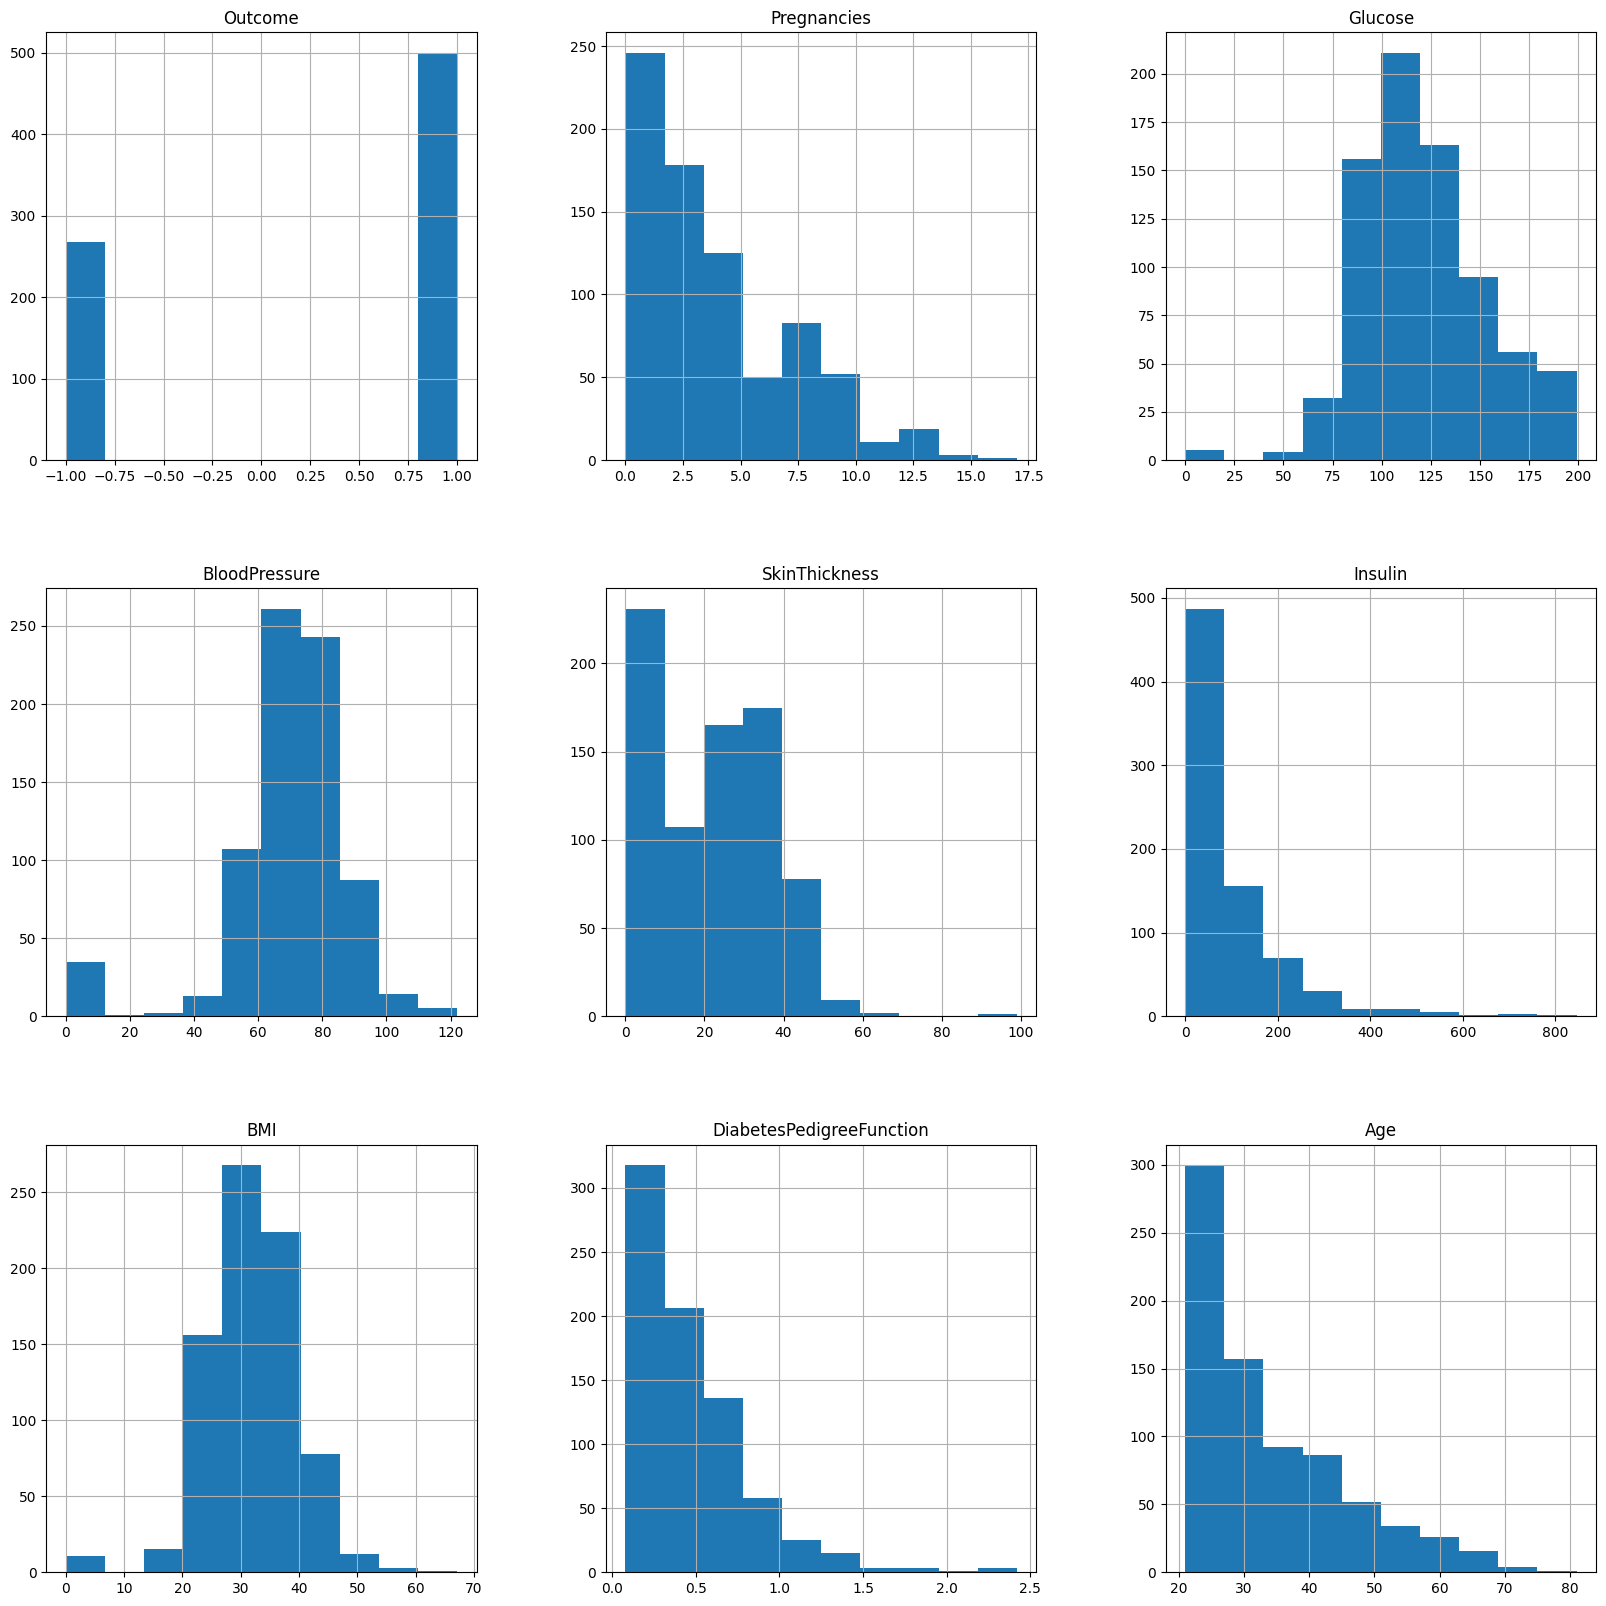

In [4]:
p = diabetes_df.hist(figsize = (20,20))

# Data scaling

In [5]:
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(diabetes_df.drop(["Outcome"],axis = 1),),
                  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                           'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [6]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103256,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409745,5.484909,-0.020496


# Train test split

In [7]:
y = diabetes_df.Outcome
# y = diabetes_df_cln.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, diabetes_df['Outcome'], test_size = 1/3, 
                                                    random_state = 48, stratify= y)

# Build Perceptron model

In [9]:
y_train = (y_train == 1).astype(float)  # Convert -1 to 0 and keep 1 as 1
y_test = (y_test == 1).astype(float)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset and DataLoader
def get_data_loader(X, y, batch_size=32):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset=dataset, batch_size=32, shuffle=True)

train_dataloader = get_data_loader(X_train_tensor, y_train_tensor)

# Single layer Perceptron model
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(SingleLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        
    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in))
    
# Model, loss function and optimizer
input_dim = X_train.shape[1]
model = SingleLayerPerceptron(input_dim)
criterion = nn.BCELoss() # Binary Cross Entropy Loss function because our output is binary
optimizer = optim.SGD(model.parameters(), lr=0.01) # Stochastic Gradient Descent with learning rate 0.01

# Model training

In [10]:
def train_model(model, train_loader, num_epochs, criterion, optimizer):
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # print(f"y_batch min: {y_batch.min().item()}, y_batch max: {y_batch.max().item()}")
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
    return model

num_epochs = 50

model = train_model(model, train_dataloader, num_epochs, criterion, optimizer)

Epoch: [1/50] Loss: 0.7310153841972351
Epoch: [11/50] Loss: 0.5786975622177124
Epoch: [21/50] Loss: 0.6210397481918335
Epoch: [31/50] Loss: 0.5050011277198792
Epoch: [41/50] Loss: 0.5463441610336304


# Model evaluation

In [12]:
# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test).sum() / y_test.shape[0]
    return accuracy.item() * 100

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 73.83%


In [14]:
# Show the learning curves
pd.DataFrame(model.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

AttributeError: 'SingleLayerPerceptron' object has no attribute 'history'

# Hyperparameter tuning

The key hyperparameters to tune are:

* Learning rate (`lr`)
* Batch size
* Number of epochs
* Optimizer type (`Adam`, `SGD`)

In [ ]:
# Hyperparameter values to try
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epoch_nums = [50, 100]
optimizers = ['adam', 'sgd']

# activation? dropout rate?

def get_optimizer(optimizer_type, model, lr):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Track the best model and accuracy
best_accuracy = 0
best_params = {}

# Loop through different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in epoch_nums:
            for opt in optimizers:
                # Print current combination of hyperparameters
                print(f'Testing: lr={lr}, batch_size={batch_size}, epochs={num_epochs}, optimizer={opt}')
                
                # Prepare DataLoader
                train_loader = get_data_loader(X_train_tensor, y_train_tensor, batch_size)
                
                # Initialize model and optimizer
                model = SingleLayerPerceptron(X_train.shape[1])
                optimizer = get_optimizer(opt, model, lr)

                # Train the model
                model = train_model(model, train_loader, num_epochs, criterion, optimizer)

                # Evaluate the model
                accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

                # Check if this is the best model
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs,
                        'optimizer': opt
                    }

                print(f'Accuracy: {accuracy:.2f}%')

# Print the best hyperparameter combination
print(f'Best accuracy: {best_accuracy:.2f}%')
print(f'Best hyperparameters: {best_params}')


Testing: lr=0.01, batch_size=16, epochs=50, optimizer=adam
Epoch: [1/50] Loss: 0.6685092449188232
Epoch: [11/50] Loss: 0.4375155568122864
Epoch: [21/50] Loss: 0.42940598726272583
Epoch: [31/50] Loss: 0.41129475831985474
Epoch: [41/50] Loss: 0.5038814544677734
Accuracy: 74.61%
Testing: lr=0.01, batch_size=16, epochs=50, optimizer=sgd
Epoch: [1/50] Loss: 0.7824933528900146
Epoch: [11/50] Loss: 0.6917526125907898
Epoch: [21/50] Loss: 0.6322656869888306
Epoch: [31/50] Loss: 0.5431177616119385
Epoch: [41/50] Loss: 0.627716064453125
Accuracy: 75.39%
Testing: lr=0.01, batch_size=16, epochs=100, optimizer=adam
Epoch: [1/100] Loss: 0.8282727599143982
Epoch: [11/100] Loss: 0.5068265199661255
Epoch: [21/100] Loss: 0.42672038078308105
Epoch: [31/100] Loss: 0.4507218897342682
Epoch: [41/100] Loss: 0.42344170808792114
Epoch: [51/100] Loss: 0.5594063401222229
Epoch: [61/100] Loss: 0.4703490734100342
Epoch: [71/100] Loss: 0.5321294665336609
Epoch: [81/100] Loss: 0.5109602808952332
Epoch: [91/100] Loss